In [1]:
import os
import time
import math
import random
import subprocess

from tqdm import tqdm
from glob import glob
from pathlib import Path
from tabulate import tabulate
from shutil import copy, copytree
from typing import Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


import tensorflow as tf
from keras import layers
import keras.backend as K
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
# from keras.utils import plot_model
from tensorflow.keras.utils import plot_model
from keras.preprocessing import image
from keras.applications import Xception
from keras.callbacks import EarlyStopping
from keras.metrics import Precision, Recall, AUC

2024-08-06 15:51:50.268453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 15:51:50.268539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 15:51:50.390152: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def download_and_extract(download_url, download_path, output_dir):
    try:
        check_dependencies()

        # Download the file without progress display
        subprocess.run(["wget", "-q", download_url, "-O", download_path], check=True)

        # Check if the download was successful before proceeding
        if os.path.exists(download_path):
            # Create the output directory
            os.makedirs(output_dir, exist_ok=True)

            # Extract the contents
            extract_command = ["tar", "-xf", download_path, "-C", output_dir]
            subprocess.run(extract_command, check=True)

            # Remove the tar file after extraction
            os.remove(download_path)
            print("Download and extraction completed successfully.")
        else:
            print("Error: Failed to download the dataset.")
    except subprocess.CalledProcessError as e:
        print(f"Error: {str(e)}")
        
def check_dependencies():
    try:
        subprocess.run(["wget", "--version"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
        subprocess.run(["tar", "--version"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Error: Dependency check failed. {e}")
        raise

In [3]:
download_url = "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar"
download_path = "/kaggle/working/256_ObjectCategories.tar"
# download_path = "/content/256_ObjectCategories.tar" # colab
output_dir = "/kaggle/working/data"
download_and_extract(download_url, download_path, output_dir)

Download and extraction completed successfully.


In [4]:
data_path = Path(r"/kaggle/working/data/256_ObjectCategories") # for kaggle
# data_path = Path(r"/content/data/256_ObjectCategories") # for colab

In [5]:
def count_images_per_class(path):
    """
    Prints the number of images in each class in the dataset.

    Parameters:
    -----------
    path: str
        A string representing the path to the data.

    Returns:
    --------
    None. Prints the number of images in each class to console.
    """

    # Printing the header for the output.
    print(f'{"Classes":>22} | {"Images":^6}')
    print("="*40)

    # Looping through each folder in the data path.
    for folder in os.listdir(path):

        # Counting the number of files in the current folder.
        sample_size = len(os.listdir(path / folder))

        # Printing the folder name and the number of files in it.
        print(f"{folder.strip():<23s}|{sample_size}")

# Call the function with the data path as an argument
count_images_per_class(data_path)

               Classes | Images
024.butterfly          |112
005.baseball-glove     |148
113.hummingbird        |116
166.praying-mantis     |92
040.cockroach          |124
138.mattress           |192
044.comet              |121
010.beer-mug           |94
061.dumb-bell          |102
177.saturn             |96
085.goat               |112
051.cowboy-hat         |114
228.triceratops        |95
224.touring-bike       |110
033.cd                 |102
140.menorah-101        |89
205.superman           |87
073.fireworks          |100
241.waterfall          |95
065.elk                |101
146.mountain-bike      |82
130.license-plate      |91
019.boxing-glove       |124
045.computer-keyboard  |85
117.ipod               |121
232.t-shirt            |358
076.football-helmet    |84
052.crab-101           |85
112.human-skeleton     |84
248.yarmulke           |84
049.cormorant          |106
018.bowling-pin        |101
202.steering-wheel     |97
091.grand-piano-101    |95
102.helicopter-101     |88
176.s

In [6]:
 def prepare_data(path: str, b_size: int) -> tuple:
    """Prepares training, validation, and test dataframes along with their respective steps.

    Args:
        path (str): The path to the directory containing the data.
        b_size (int): The batch size for training.

    Returns:
        tuple: A tuple containing the training dataframe, validation dataframe, test dataframe,
        training steps, validation steps, and test steps.
    """
    file_paths = []
    labels = []

    for claass in sorted(os.listdir(path)):
        c_pth = os.path.join(path, claass)

        for file in os.listdir(c_pth):
            file_path = os.path.join(c_pth, file)
            file_paths.append(file_path)
            labels.append(claass)

    print(f"Files: {len(file_paths)}\nLabels: {len(labels)}\n")

    files_series = pd.Series(file_paths, name="file_paths")
    labels_series = pd.Series(labels, name="labels")

    d = pd.concat([files_series, labels_series], axis=1)

    train_d, test_data_d = train_test_split(d, test_size=.2, stratify=d.labels, random_state=81)
    train_d, valid_d = train_test_split(train_d, test_size=.2, stratify=train_d.labels, random_state=81)

    print(f"Training Data: {train_d.shape[0]} samples\nTesting Data: {test_data_d.shape[0]} samples\nValidation Data: {valid_d.shape[0]} samples\n")

    return d, labels, train_d, valid_d, test_data_d

BATCH_SIZE = 6
df, labels, train_df, valid_df, test_df = prepare_data(data_path, BATCH_SIZE)

Files: 30609
Labels: 30609

Training Data: 19589 samples
Testing Data: 6122 samples
Validation Data: 4898 samples



In [7]:
def create_counts_table(d, test_d, train_d, valid_d):
    # Creating lists of the "labels" column from the data frames.
    df_labels = d["labels"]
    test_labels = test_d["labels"]
    train_labels = train_d["labels"]
    valid_labels = valid_d["labels"]

    # Printing the header for the output.
    print(f'{"Class":>19} | {"Test":^4} | {"Train":^5} | {"Valid":^5}')
    print("="*50)

    # Looping through each unique class in the "labels" column.
    for c in df_labels.unique():

        # Counting the number of times the current class appears in each data frame.
        test_count = list(test_labels).count(c)
        train_count = list(train_labels).count(c)
        valid_count = list(valid_labels).count(c)

        # Printing the class name and the counts for each data frame.
        print(f"{c:>19} | {test_count:^4} | {train_count:^5} | {valid_count}")

create_counts_table(df, test_df, train_df, valid_df)

              Class | Test | Train | Valid
           001.ak47 |  20  |  62   | 16
  002.american-flag |  19  |  62   | 16
       003.backpack |  30  |  97   | 24
   004.baseball-bat |  25  |  82   | 20
 005.baseball-glove |  30  |  94   | 24
006.basketball-hoop |  18  |  58   | 14
            007.bat |  21  |  68   | 17
        008.bathtub |  47  |  148  | 37
           009.bear |  20  |  66   | 16
       010.beer-mug |  19  |  60   | 15
      011.billiards |  56  |  177  | 45
     012.binoculars |  43  |  138  | 35
       013.birdbath |  20  |  62   | 16
          014.blimp |  17  |  55   | 14
     015.bonsai-101 |  24  |  78   | 20
       016.boom-box |  18  |  58   | 15
   017.bowling-ball |  21  |  66   | 17
    018.bowling-pin |  20  |  65   | 16
   019.boxing-glove |  25  |  79   | 20
      020.brain-101 |  17  |  53   | 13
     021.breadmaker |  28  |  91   | 23
     022.buddha-101 |  19  |  62   | 16
      023.bulldozer |  22  |  70   | 18
      024.butterfly |  22  |  72   | 

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_data(df, b_size=BATCH_SIZE, shuffle=True, random_state=81, workers=1):
    generator = ImageDataGenerator(
        rescale=1 / 255.,
        # Add more augmentation parameters if needed
    )

    data = generator.flow_from_dataframe(
        df,
        x_col="file_paths",
        y_col="labels",
        target_size=(224, 224),
        class_mode="categorical",
        shuffle=shuffle,
        batch_size=b_size,
        seed=random_state,
        workers=workers
    )

    # Print a warning for invalid filenames
    invalid_filenames = df.loc[~df['file_paths'].isin(data.filenames), 'file_paths']
    if not invalid_filenames.empty:
        print("Warning: Invalid filenames found and will be ignored:", invalid_filenames.tolist())

    return data

# Load the training, validation, and test data with consistent random_state
train_data = load_data(train_df)
valid_data = load_data(valid_df, shuffle=False)
test_data = load_data(test_df, shuffle=False)

Found 19587 validated image filenames belonging to 257 classes.
Found 4898 validated image filenames belonging to 257 classes.
Found 6122 validated image filenames belonging to 257 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="file_paths". These filename(s) will be ignored.
  warnings.warn(


In [9]:
import tensorflow.keras.backend as K
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    )

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_bn(x, filters, kernel_size, strides):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=6.0)(x)
    return x

def conv_1x1_bn(x, filters):
    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=6.0)(x)
    return x

def inverted_res_block(x, filters, stride, expand_ratio):
    input_shape = tf.keras.backend.int_shape(x)
    in_channels = input_shape[-1]
    hidden_dim = in_channels * expand_ratio
    use_res_connect = (stride == 1 and in_channels == filters)

    residual_input = x  # Renamed the input to avoid conflict with reserved keyword

    if expand_ratio != 1:
        x = conv_1x1_bn(x, hidden_dim)

    x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=6.0)(x)

    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if use_res_connect:
        return layers.add([x, residual_input])
    else:
        return x

def MobileNetV2(input_shape=(224, 224, 3), n_class=1000, width_mult=1.0):
    input_tensor = layers.Input(shape=input_shape)
    x = conv_bn(input_tensor, int(32 * width_mult), 3, 2)

    inverted_residual_setting = [
        # t, c, n, s
        [1, 16, 1, 1],
        [6, 24, 2, 2],
        [6, 32, 3, 2],
        [6, 64, 4, 2],
        [6, 96, 3, 1],
        [6, 160, 3, 2],
        [6, 320, 1, 1],
    ]

    for t, c, n, s in inverted_residual_setting:
        out_channels = int(c * width_mult)
        for i in range(n):
            if i == 0:
                x = inverted_res_block(x, out_channels, s, t)
            else:
                x = inverted_res_block(x, out_channels, 1, t)

    last_channel = int(1280 * width_mult) if width_mult > 1.0 else 1280
    x = conv_1x1_bn(x, last_channel)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(n_class, activation='softmax')(x)

    model = models.Model(input_tensor, output)
    return model




In [17]:
model = MobileNetV2(input_shape=(224, 224, 3), n_class=257)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_35 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_17 │ (None, 112, 112,  │        288 │ re_lu_35[0][0]    │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 112, 112,  │        512 │ re_lu_36[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 112, 112,  │      1,536 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        384 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_37 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_18 │ (None, 56, 56,    │        864 │ re_lu_37[0][0]    │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        384 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_38 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 56, 56,    │      2,304 │ re_lu_38[0][0]    │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         96 │ conv2d_38[0][0] 

 Total params: 2,587,201 (9.87 MB)

 Trainable params: 2,553,089 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
plot_model(model, to_file='modified_model.png', show_shapes=True, show_layer_activations=True)

In [ ]:
class TimeCallback(tf.keras.callbacks.Callback):
    """Custom callback to record epoch times and total training time."""

    def on_train_begin(self, logs=None):
        """Initialize training start time and epoch times."""
        self.train_start_time = time.perf_counter()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        """Record start time of each epoch."""
        self.epoch_start_time = time.perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        """Calculate and store epoch time."""
        epoch_time = time.perf_counter() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

    def on_train_end(self, logs=None):
        """Calculate total training time."""
        self.total_train_time = time.perf_counter() - self.train_start_time

time_callback = TimeCallback()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
from keras.callbacks import LearningRateScheduler

learningRate = 1e-4
decayRate = 0.97

def lr_schedule(epoch):
    if epoch < 2:
        return learningRate
    else:
        return learningRate * decayRate ** epoch

learning_callback = LearningRateScheduler(lr_schedule)

In [22]:
custom_metrics = list(create_metrics())
custom_metrics.append("accuracy")

model.compile(
    optimizer=Adam(learning_rate=learningRate),
    loss='categorical_crossentropy',
    metrics=custom_metrics
)

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=50,
    callbacks=[time_callback, early_stopping]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   2/3265 ━━━━━━━━━━━━━━━━━━━━ 2:50 52ms/step - accuracy: 0.0000e+00 - auc_1: 0.6009 - f1_score: 0.0000e+00 - loss: 5.6269 - mcc: 0.0000e+00 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 1.0000   

I0000 00:00:1722959753.047072     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722959753.108953     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3197/3265 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.0548 - auc_1: 0.5947 - f1_score: 0.0094 - loss: 5.4220 - mcc: 0.0133 - precision_1: 0.5763 - recall_1: 0.0055 - sensitivity: 0.0055 - specificity: 1.0000

W0000 00:00:1722959872.718087     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3265/3265 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.0551 - auc_1: 0.5955 - f1_score: 0.0097 - loss: 5.4178 - mcc: 0.0137 - precision_1: 0.5811 - recall_1: 0.0057 - sensitivity: 0.0057 - specificity: 1.0000

W0000 00:00:1722959879.164891     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3265/3265 ━━━━━━━━━━━━━━━━━━━━ 195s 43ms/step - accuracy: 0.0551 - auc_1: 0.5955 - f1_score: 0.0097 - loss: 5.4177 - mcc: 0.0137 - precision_1: 0.5812 - recall_1: 0.0057 - sensitivity: 0.0057 - specificity: 1.0000 - val_accuracy: 0.0998 - val_auc_1: 0.7053 - val_f1_score: 0.0808 - val_loss: 4.8807 - val_mcc: 0.1065 - val_precision_1: 0.5000 - val_recall_1: 0.0500 - val_sensitivity: 0.0500 - val_specificity: 0.9998
Epoch 2/50


W0000 00:00:1722959893.469788     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3265/3265 ━━━━━━━━━━━━━━━━━━━━ 107s 33ms/step - accuracy: 0.1010 - auc_1: 0.7166 - f1_score: 0.0481 - loss: 4.8111 - mcc: 0.0676 - precision_1: 0.8166 - recall_1: 0.0284 - sensitivity: 0.0284 - specificity: 1.0000 - val_accuracy: 0.1407 - val_auc_1: 0.7516 - val_f1_score: 0.1250 - val_loss: 4.6269 - val_mcc: 0.1600 - val_precision_1: 0.5660 - val_recall_1: 0.0796 - val_sensitivity: 0.0796 - val_specificity: 0.9998
Epoch 3/50
3265/3265 ━━━━━━━━━━━━━━━━━━━━ 107s 33ms/step - accuracy: 0.1336 - auc_1: 0.7724 - f1_score: 0.0754 - loss: 4.4805 - mcc: 0.1041 - precision_1: 0.8423 - recall_1: 0.0451 - sensitivity: 0.0451 - specificity: 1.0000 - val_accuracy: 0.1613 - val_auc_1: 0.7903 - val_f1_score: 0.1412 - val_loss: 4.3483 - val_mcc: 0.1789 - val_precision_1: 0.5881 - val_recall_1: 0.0906 - val_sensitivity: 0.0906 - val_specificity: 0.9998
Epoch 4/50
3265/3265 ━━━━━━━━━━━━━━━━━━━━ 107s 33ms/step - accuracy: 0.1654 - auc_1: 0.8141 - f1_score: 0.1004 - loss: 4.1814 - mcc: 0.1388 - precision_1

In [ ]:
execution_time_parts = []
avg_time_parts = []

for unit in [(3600, 'hours'), (60, 'minutes'), (1, 'seconds'), (0.001, 'milliseconds')]:
    total_value = int(time_callback.total_train_time // unit[0])
    avg_value = int(np.mean(time_callback.epoch_times) // unit[0])

    if total_value > 0 or unit[0] == 0.001:
        execution_time_parts.append((total_value, unit[1]))
    if avg_value > 0 or unit[0] == 0.001:
        avg_time_parts.append((avg_value, unit[1]))

    time_callback.total_train_time -= total_value * unit[0]
    time_callback.epoch_times = [time - avg_value * unit[0] for time in time_callback.epoch_times]

execution_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in execution_time_parts if value > 0
])

avg_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in avg_time_parts if value > 0
])

print(f"Model training took {execution_time_string}")
print(f"Average time per epoch: {avg_time_string}")

In [23]:
_ = model.evaluate(test_data)

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.3774 - auc_1: 0.8761 - f1_score: 0.3728 - loss: 3.1282 - mcc: 0.4113 - precision_1: 0.6824 - recall_1: 0.2755 - sensitivity: 0.2755 - specificity: 0.9995


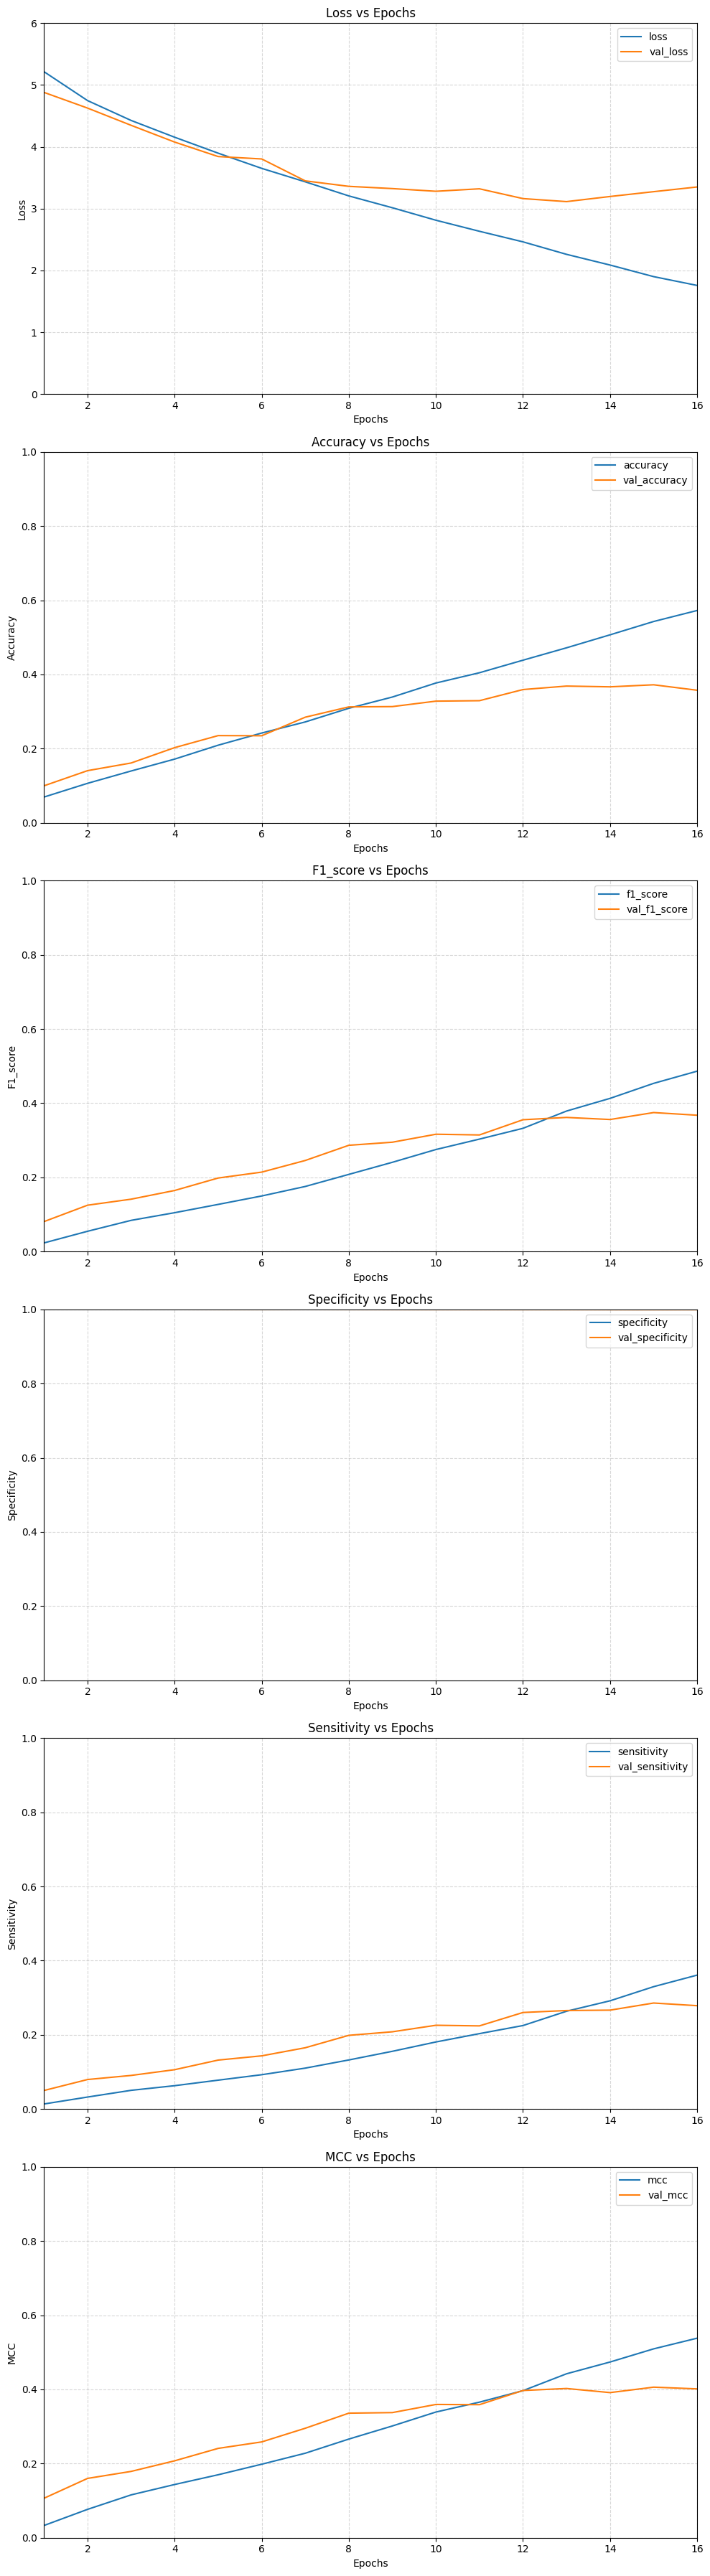

In [24]:
def plot_metrics(history, metric_name_list, figure_size=(10, 6)):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        history: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot
        figure_size: a tuple specifying the size of the figure (width, height)

    Returns:
        None
    """
    # Check if history is a valid Keras History object
    if not isinstance(history, type(tf.keras.callbacks.History())):
        raise ValueError("Invalid Keras History object provided.")

    num_metrics = len(metric_name_list)

    # Create subplots
    figure, axes = plt.subplots(num_metrics, figsize=(figure_size[0], figure_size[1] * num_metrics))

    # Define x-axis range
    rng = range(1, len(history.history[metric_name_list[0]]) + 1)

    for ax, metric_name in zip(axes, metric_name_list):
        # Check if the metric exists in the history
        if metric_name not in history.history:
            raise ValueError(f"Metric '{metric_name}' not found in the training history.")

        metric = history.history[metric_name]
        v_metric = history.history.get(f"val_{metric_name}", None)

        # Plot training metric
        ax.plot(rng, metric, label=metric_name)

        # Plot validation metric if available
        if v_metric is not None:
            ax.plot(rng, v_metric, label=f"val_{metric_name}")

        ax.legend()
        ax.set_xlabel("Epochs")

        # Set y-axis label and title
        ylabel = metric_name.upper() if metric_name in ("auc", "mcc") else metric_name.capitalize()
        ax.set_ylabel(ylabel)
        ax.set_title(f"{ylabel} vs Epochs")

        # Set y-axis limits
        max_loss = max(max(metric), max(v_metric)) if v_metric is not None else max(metric)
        min_loss = min(min(metric), min(v_metric)) if v_metric is not None else min(metric)
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()
    plt.show()

metric_names = ["loss", "accuracy",  "f1_score",
                "specificity", "sensitivity", "mcc"]
plot_metrics(history, metric_names)